In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","strobl_simulation")
today_str = datetime.today().strftime("%Y%m%d")

In [5]:
# #Import Tree Models from scratch functions
# import sys
# import os

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path+"/TreeModelsFromScratch")

# from DecisionTree import DecisionTree
# from RandomForest import RandomForest
# from SmoothShap import verify_shap_model, smooth_shap

# Development and testing of function

## Regression

In [6]:
X_dia, y_dia = datasets.load_diabetes(return_X_y=True, as_frame=True)

### Test of adapted HS formula for single Tree

In [43]:
# Instantiate tree
reg_tree = DecisionTree(max_depth=2, treetype="regression", HShrinkage=False, HS_lambda=0, random_state=42)
HSreg_tree = DecisionTree(max_depth=2, treetype="regression", HShrinkage=True, HS_lambda=10, random_state=42)

In [44]:
# fit trees
reg_tree.fit(X_dia, y_dia)
HSreg_tree.fit(X_dia, y_dia)

In [45]:
# Apply HS post hoc
reg_tree.HS_lambda = 10
reg_tree._apply_hierarchical_srinkage(treetype=reg_tree.treetype)
reg_tree._create_node_dict()

In [46]:
# create dummy list with smooth shap reg coef of 1 
smSHAP_coefs = [1.]*10

In [47]:
# reinstantiate and fit tree
reg_tree = DecisionTree(max_depth=2, treetype="regression", HShrinkage=False, HS_lambda=0, random_state=42)
reg_tree.fit(X_dia, y_dia)

In [48]:
[node.feature for node in reg_tree.node_list]

[8, 2, None, None, 2, None, None]

In [49]:
# Apply HS post hoc
reg_tree.HS_lambda = 10
reg_tree._apply_hierarchical_srinkage(treetype=reg_tree.treetype, smooth_shap_coefs=smSHAP_coefs)
reg_tree._create_node_dict()

In [50]:
HS_vals = [node.value for node in HSreg_tree.node_list]
reg_tree_vals = [node.value for node in reg_tree.node_list]

In [51]:
reg_tree_vals == HS_vals

True

In [52]:
# reinstantiate and fit tree
reg_tree = DecisionTree(max_depth=2, treetype="regression", HShrinkage=False, HS_lambda=0, random_state=42)
reg_tree.fit(X_dia, y_dia)

In [53]:
smSHAP_coefs[2]=0.6

In [55]:
# Apply HS post hoc
clf_tree.HS_lambda = 10
reg_tree._apply_hierarchical_srinkage(treetype=reg_tree.treetype, smooth_shap_coefs=smSHAP_coefs)
reg_tree._create_node_dict()

In [56]:
reg_tree_vals = [node.value for node in reg_tree.node_list]

In [57]:
reg_tree_vals

[152.13348416289594,
 127.40461349633752,
 114.32815407292517,
 174.98066799428452,
 176.19997436517153,
 147.03139198969262,
 207.52919247216738]

In [58]:
HS_vals

[152.13348416289594,
 110.9186997186319,
 97.84224029521955,
 158.49475421657888,
 192.24430116668862,
 163.07571879120968,
 223.57351927368447]

### Test of new formula for RF (post-hoc)

In [116]:
rf_reg = RandomForest(n_trees=25, treetype="regression", oob_SHAP=True, random_state=42)

In [117]:
rf_reg.fit(X_dia, y_dia)

In [118]:
from sklearn.metrics import mean_squared_error

In [119]:
mean_squared_error(y_dia, rf_reg.predict(X_dia))

514.6047954751131

In [120]:
rf_reg.apply_smSHAP_HS(HS_lambda=1)

In [121]:
mean_squared_error(y_dia, rf_reg.predict(X_dia))

1760.942155947934

In [124]:
rf_reg.smSHAP_coefs

[0.23959616420636656,
 0.7486406255795,
 0.7861052166540966,
 0.6644095880660855,
 0.07315485993502402,
 0.07767002270288169,
 0.6710471131660917,
 0.43644352652373203,
 0.828298124838711,
 0.5544341966374144]

### Test of new formula for RF (during fit)

In [10]:
rf_reg = RandomForest(n_trees=25, treetype="regression", oob_SHAP=True, HS_smSHAP=True, HS_lambda=10, random_state=42)
rf_reg.fit(X_dia, y_dia)

In [11]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_dia, rf_reg.predict(X_dia))

2354.432094542294

## Classification

In [12]:
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

### Test of adapted HS formula for single Tree

In [88]:
# Instantiate tree
clf_tree = DecisionTree(max_depth=2, treetype="classification", HShrinkage=False, HS_lambda=0, random_state=42)
HSclf_tree = DecisionTree(max_depth=2, treetype="classification", HShrinkage=True, HS_lambda=10, random_state=42)

In [89]:
# fit trees
clf_tree.fit(X, y)
HSclf_tree.fit(X, y)

In [90]:
# Apply HS post hoc
clf_tree.HS_lambda = 10
clf_tree._apply_hierarchical_srinkage(treetype=clf_tree.treetype)
clf_tree._create_node_dict()

In [91]:
HS_vals = [node.clf_prob_dis for node in HSclf_tree.node_list]
clf_tree_vals = [node.clf_prob_dis for node in clf_tree.node_list]

In [94]:
np.array_equal(HS_vals, clf_tree_vals)

True

In [95]:
# create dummy list with smooth shap reg coef of 1 
smSHAP_coefs = [1.]*len(clf_tree.features_in_)

In [96]:
# reinstantiate and fit tree
clf_tree = DecisionTree(max_depth=2, treetype="classification", HShrinkage=False, HS_lambda=0, random_state=42)
clf_tree.fit(X, y)

In [97]:
[node.feature for node in clf_tree.node_list]

[20, 27, None, None, 21, None, None]

In [98]:
# Apply HS post hoc
clf_tree.HS_lambda = 10
clf_tree._apply_hierarchical_srinkage(treetype=clf_tree.treetype, smooth_shap_coefs=smSHAP_coefs)
clf_tree._create_node_dict()

In [99]:
clf_tree_vals = [node.clf_prob_dis for node in clf_tree.node_list]

In [100]:
np.array_equal(HS_vals, clf_tree_vals)

True

In [101]:
# reinstantiate and fit tree
clf_tree = DecisionTree(max_depth=2, treetype="classification", HShrinkage=False, HS_lambda=0, random_state=42)
clf_tree.fit(X, y)

In [102]:
smSHAP_coefs[27]=0.6

In [103]:
# Apply HS post hoc
clf_tree.HS_lambda = 10
clf_tree._apply_hierarchical_srinkage(treetype=clf_tree.treetype, smooth_shap_coefs=smSHAP_coefs)
clf_tree._create_node_dict()

In [104]:
clf_tree_vals = [node.clf_prob_dis for node in clf_tree.node_list]

In [105]:
np.array_equal(HS_vals, clf_tree_vals)

False

In [106]:
clf_tree_vals

[array([0.37258348, 0.62741652]),
 array([0.20423481, 0.79576519]),
 array([0.13403093, 0.86596907]),
 array([0.71244986, 0.28755014]),
 array([0.93226896, 0.06773104]),
 array([0.48432779, 0.51567221]),
 array([0.9762863, 0.0237137])]

In [107]:
HS_vals

[array([0.37258348, 0.62741652]),
 array([0.09200237, 0.90799763]),
 array([0.02179849, 0.97820151]),
 array([0.60021741, 0.39978259]),
 array([0.93226896, 0.06773104]),
 array([0.48432779, 0.51567221]),
 array([0.9762863, 0.0237137])]

### Test of new formula for RF (during fit)

In [13]:
### Test of new formula for RF (during fit)
clf_reg = RandomForest(n_trees=25, treetype="classification", oob_SHAP=True, HS_smSHAP=True, HS_lambda=10, random_state=42)
clf_reg.fit(X, y)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y, clf_reg.predict(X))

0.9929701230228472

# Strobl

In [41]:
import numbers

In [42]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [46]:
# for random forests and smooth shap
def simulate_data_simpleRF(n=120, M=100, n_trees=50, relevance_power=0.15, reg_param=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)

    featimp_scrHSsmSHAP_null = []
    featimp_scrHSsmSHAP_power = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)   
    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)
    
    for i in range(M):
        
        # fit scratch Smooth SHAP 
        clf_null_scrHSsmSHAP = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification", 
                                      HShrinkage=False, HS_lambda=reg_param, oob=True, 
                                      HS_smSHAP=True, oob_SHAP=True, random_state=random_seed)
        clf_null_scrHSsmSHAP.fit(X_null[i,:,:], y_null[:,i])

        export_model = clf_null_scrHSsmSHAP.export_forest_for_SHAP()
        explainer = shap.TreeExplainer(export_model)
        shap_values_scrHS_null = explainer.shap_values(X_null[i,:,:])
        shap_values_scrHS_null_inbag = clf_null_scrHSsmSHAP.inbag_SHAP_values
        shap_values_scrHS_null_oob = clf_null_scrHSsmSHAP.oob_SHAP_values
        shap_values_scrHS_null_smooth = clf_null_scrHSsmSHAP.smSHAP_vals
        
        featimp_scrHSsmSHAP_null.append([shap_values_scrHS_null, shap_values_scrHS_null_inbag, shap_values_scrHS_null_oob, shap_values_scrHS_null_smooth])  

        #Fit scratch HS mooth shap
        clf_power_scrHSsmSHAP = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification", 
                                        HShrinkage=False, HS_lambda=reg_param, HS_smSHAP=True,
                                        oob=True, oob_SHAP=True, random_state=random_seed)
        clf_power_scrHSsmSHAP.fit(X_power[i,:,:], y_power[:,i])

        export_model = clf_power_scrHSsmSHAP.export_forest_for_SHAP()
        explainer = shap.TreeExplainer(export_model)
        shap_values_scrHS_power = explainer.shap_values(X_null[i,:,:])
        shap_values_scrHS_power_inbag = clf_power_scrHSsmSHAP.inbag_SHAP_values
        shap_values_scrHS_power_oob = clf_power_scrHSsmSHAP.oob_SHAP_values
        shap_values_scrHS_power_smooth = clf_power_scrHSsmSHAP.smSHAP_vals
                    
        featimp_scrHSsmSHAP_power.append([shap_values_scrHS_power, shap_values_scrHS_power_inbag, shap_values_scrHS_power_oob, shap_values_scrHS_power_smooth])
        
    
    return [X_null, y_null], [X_power, y_power], featimp_scrHSsmSHAP_null, featimp_scrHSsmSHAP_power


In [49]:
%%time
[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], shap_imps_nullRF, shap_imps_powerRF = simulate_data_simpleRF(
    n=120, M=100, n_trees=100, reg_param=10, random_seed=42)

CPU times: user 32min 6s, sys: 1.65 s, total: 32min 7s
Wall time: 32min 7s


In [53]:
#Store results as pkl
RF_HS_SmSHAP_100 = [[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], shap_imps_nullRF, shap_imps_powerRF]

with open(f'{data_path}/{today_str}_RF_HS_SmSHAP_100.pickle', 'wb') as handle:
    pickle.dump(RF_HS_SmSHAP_100, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load pickle results
# with open(f'{data_path}/20221027_RF_SHAP_15.pickle', 'rb') as handle:
#     RF_SHAP_15 = pickle.load(handle)
#     [[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], shap_imps_nullRF, shap_imps_powerRF] = RF_SHAP_15

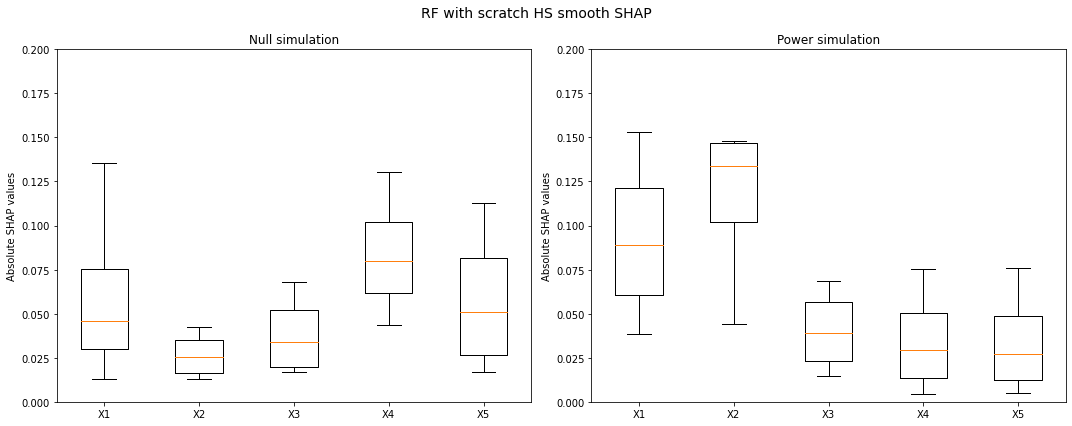

In [56]:
#Null simulation
fig, axs = plt.subplots(1,2, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('RF with scratch HS smooth SHAP', fontsize=14)

axs[0].boxplot(np.abs(np.array(shap_imps_nullRF[0])).mean(axis=1), labels=x_label)
axs[0].set_title('Null simulation')
axs[0].set_ylabel("Absolute SHAP values")

axs[1].boxplot(np.abs(np.array(shap_imps_powerRF[1])).mean(axis=1), labels=x_label)
axs[1].set_title('Power simulation')
axs[1].set_ylabel("Absolute SHAP values")

plt.setp(axs, ylim=[0,0.2]) #set global ylim for all suplots

fig.tight_layout();

# Titanic dataset

The datast from OpenML seems to be ordered and does not come with the PassengerId column. Therefore we use the dataset from kaggle.

In [112]:
# from sklearn.datasets import fetch_openml
 
# # load dataset
# data = fetch_openml('titanic', version=1)["frame"]
# data.drop(['name', 'boat', 'body', 'home.dest', 'cabin', 'embarked', 'sibsp', 'parch', 'ticket', 'fare'], axis=1, inplace=True)
# data = data.reset_index()
# data.rename(columns={"index":"pid"}, inplace=True)
# data = data[data["age"].notnull()]
# data["sex"] = pd.get_dummies(data["sex"])["female"]

In [114]:
# X = data[['pid', 'pclass', 'sex', 'age']]
# y = data["survived"].astype("float")

In [216]:
data = pd.read_csv("../data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [217]:
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### HS with SmoothSHAP incl. GridSearch 

In [223]:
clf_HSsmSHAP = RandomForest(n_trees= 100, treetype="classification", 
                    HShrinkage=False, oob=True, HS_smSHAP=True, oob_SHAP=True, 
                    random_state=42)

In [224]:
grid = {"HS_lambda":[0.1, 1, 10, 20, 50, 100]}

In [225]:
clf_HSsmSHAP_cvresults = GridSearchCV_scratch(estimator=clf_HSsmSHAP, grid=grid, X=X_train, 
    y=y_train, cv=3, scoring_func=accuracy_score)

In [226]:
clf_HSsmSHAP_cvresults

{'best_param_comb': (10,),
 'best_test_score': 0.8256739532982228,
 'mean_test_scores': array([0.81161773, 0.79762162, 0.82567395, 0.81565784, 0.77756535,
        0.77962148]),
 'param_combinations': [(0.1,), (1,), (10,), (20,), (50,), (100,)],
 'cv_scores_p_split': array([[0.81437126, 0.77710843, 0.84337349],
        [0.78443114, 0.8373494 , 0.77108434],
        [0.81437126, 0.8313253 , 0.8313253 ],
        [0.80239521, 0.78313253, 0.86144578],
        [0.77245509, 0.79518072, 0.76506024],
        [0.74850299, 0.78915663, 0.80120482]])}

In [227]:
clf_HSsmSHAP.HS_lambda

10

In [229]:
[node.id for node in clf_HSsmSHAP.trees[0].node_list if node.feature_name =="PassengerId"][0]

2

In [230]:
clf_HSsmSHAP.trees[0].node_id_dict[2]

{'node': <TreeModelsFromScratch.DecisionTree.Node at 0x7fab08dc8898>,
 'id': 2,
 'depth': 2,
 'feature': 'PassengerId',
 'is_leaf_node': False,
 'threshold': 181.5,
 'gini': 0.4981634527089073,
 'samples': 66,
 'value': 0,
 'value_distribution': [35, 31],
 'prob_distribution': [0.666213094886419, 0.3337869051135811]}

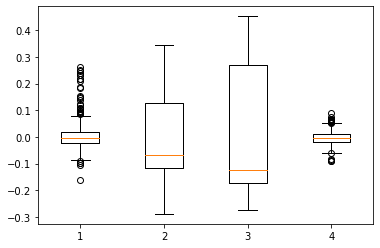

In [231]:
plt.boxplot(clf_HSsmSHAP.smSHAP_vals);

In [ ]:
clf_HSsmSHAP.smSHAP_coefs

[0.5556030011873505, 0.8417773074860381, 0.99566737651571, 0.7308930142080764]

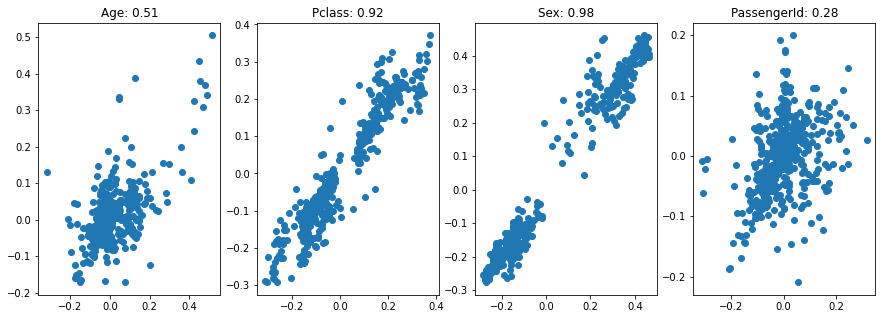

In [232]:
fig, axs = plt.subplots(1,4, figsize=(15,5))

for i in range(4):
    axs[i].scatter(clf_HSsmSHAP.inbag_SHAP_values[:, i].reshape(-1, 1), clf_HSsmSHAP.oob_SHAP_values[:, i])
    axs[i].set_title(f"{clf_HSsmSHAP.feature_names[i]}: {np.round(clf_HSsmSHAP.smSHAP_coefs[i],2)}")

In [233]:
export_model_rfHSsmSH = clf_HSsmSHAP.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_rfHSsmSH = shap.TreeExplainer(export_model_rfHSsmSH)

# Compute shap scores of RF for train data
shap_vals_rfHSsmSH_raw = explainer_rfHSsmSH.shap_values(X_train, y_train)

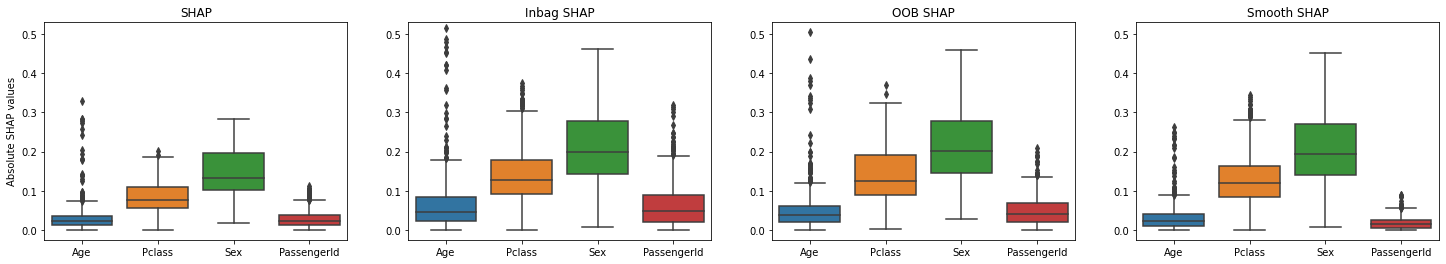

In [234]:
# Comparison of absolute value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,4))


sns.boxplot(data=np.abs(shap_vals_rfHSsmSH_raw), ax =axs[0])
sns.boxplot(data=np.abs(clf_HSsmSHAP.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(clf_HSsmSHAP.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(clf_HSsmSHAP.smSHAP_vals), ax =axs[3])


axs[0].set_title("SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());

### HS incl. GridSearch 

In [235]:
clf_HS = RandomForest(n_trees= 100, treetype="classification", 
                    HShrinkage=True, oob=False, HS_smSHAP=False, oob_SHAP=False, 
                    random_state=42)

In [236]:
clf_HS_cvresults = GridSearchCV_scratch(estimator=clf_HS, grid=grid, X=X_train, 
    y=y_train, cv=3, scoring_func=accuracy_score)

In [237]:
clf_HS_cvresults

{'best_param_comb': (10,),
 'best_test_score': 0.8216458648967127,
 'mean_test_scores': array([0.80560566, 0.80764976, 0.82164586, 0.80959767, 0.77550922,
        0.7856095 ]),
 'param_combinations': [(0.1,), (1,), (10,), (20,), (50,), (100,)],
 'cv_scores_p_split': array([[0.80838323, 0.81325301, 0.79518072],
        [0.79041916, 0.78313253, 0.84939759],
        [0.82035928, 0.81325301, 0.8313253 ],
        [0.82035928, 0.81927711, 0.78915663],
        [0.79640719, 0.75301205, 0.77710843],
        [0.76646707, 0.80722892, 0.78313253]])}

In [239]:
[node.id for node in clf_HS.trees[0].node_list if node.feature_name =="PassengerId"][0]

2

In [240]:
clf_HS.trees[0].node_id_dict[2]

{'node': <TreeModelsFromScratch.DecisionTree.Node at 0x7fab08e90fd0>,
 'id': 2,
 'depth': 2,
 'feature': 'PassengerId',
 'is_leaf_node': False,
 'threshold': 181.5,
 'gini': 0.4981634527089073,
 'samples': 66,
 'value': 0,
 'value_distribution': [35, 31],
 'prob_distribution': [0.5332891860387985, 0.46671081396120156]}

### Regular RF

In [ ]:
cross_val_score_scratch()

In [242]:
clf_rf = RandomForest(n_trees= 100, treetype="classification", 
                    HShrinkage=False, oob=True, HS_smSHAP=False, oob_SHAP=True, 
                    random_state=42)

clf_rf_cv_scores = cross_val_score_scratch(clf_rf, X_train, y_train, cv=3, scoring_func=accuracy_score)


In [244]:
np.mean(clf_rf_cv_scores)

0.7835533751773562

In [245]:
clf_rf.fit(X_train, y_train)

In [246]:
export_model_rf = clf_rf.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_rf = shap.TreeExplainer(export_model_rf)

# Compute shap scores of RF for train data
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

In [247]:
smooth_shap_vals, mean_smooth_shap, lin_coefs = smooth_shap(clf_rf.inbag_SHAP_values, clf_rf.oob_SHAP_values)

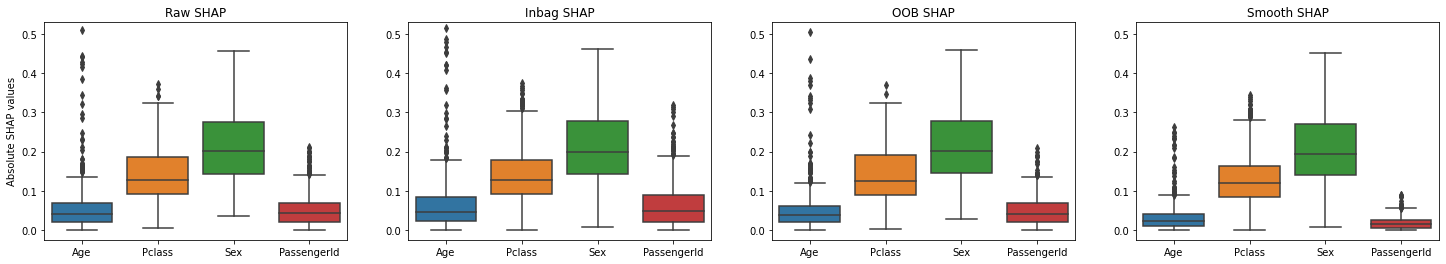

In [248]:
# Comparison of absolute value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,4))


sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
sns.boxplot(data=np.abs(clf_rf.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(clf_rf.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(smooth_shap_vals), ax =axs[3])


axs[0].set_title("Raw SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());

# Toy dataset from HS paper

In [272]:
def plot_sim(n=50, std=1, reg_param=0, show=True, linear_data=False, return_curves=False, use_imodels=True, gridsearch_lambda=False, ax=None):
    
    if ax == None:
        ax = plt.axes()
    
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std


    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    #return X, y, X_tile, y_tile
    
    # for original plots use sklearn and imodels
    if use_imodels:
        m1 = DecisionTreeRegressor(random_state=1)  #, max_leaf_nodes=15)
        m1.fit(X.reshape(-1, 1), y)
        y_pred_dt = m1.predict(X_tile.reshape(-1, 1))

        mshrunk = imodels.HSTreeRegressor(deepcopy(m1), reg_param=reg_param)
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))

    #use TreeModelsfromScratch package
    else:
        m1 = DecisionTree(treetype="regression", random_state=1)
        m1.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_dt = m1.predict(X_tile.reshape(-1,1))
        
        mshrunk = DecisionTree(treetype="regression", HShrinkage=True, HS_lambda=reg_param, random_state=1)
        mshrunk.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))

        if gridsearch_lambda:
            grid = {"HS_lambda":[0.1,1,5,10,20,50,100]}
            mshrunksmSHAP = RandomForest(n_trees=100, treetype="regression", HS_lambda=reg_param, oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=1)
            mshrunksmSHAP_cv = GridSearchCV_scratch(mshrunksmSHAP, grid, X.reshape(-1,1), y.reshape(-1,1), 3, r2_score)
        else:
            mshrunksmSHAP = RandomForest(n_trees=100, treetype="regression", HS_lambda=reg_param, oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=1)
            mshrunksmSHAP.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_shrunksmSHAP = mshrunksmSHAP.predict(X_tile.reshape(-1, 1))
    
    ax.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)    
    ax.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3)    
    ax.plot(X_tile, y_pred_dt, '-', label='CART', color="skyblue", alpha=0.5, lw=4)
    ax.plot(X_tile, y_pred_shrunk, label='hsCART', color='#ff4b33', alpha=0.5, lw=4)
    ax.plot(X_tile, y_pred_shrunksmSHAP, label='hsSmSHAP_RF', color='green', alpha=0.5, lw=4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    #dvu.line_legend(adjust_text_labels=False)
    # if show == 'save':
    #     ax.savefig(f'gif/{reg_param}.svg')
    # elif show == 'pass':
    #     pass
    # elif show:
    #     ax.show()
    # else:
    #     ax.close()

    if return_curves:
        if gridsearch_lambda:
            return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk, y_pred_shrunksmSHAP, mshrunksmSHAP_cv
        return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk, y_pred_shrunksmSHAP

#     print('dt', export_text(m1, feature_names=['X']))
#     print('dt', export_text(mshrunk.estimator_, feature_names=['X']))

# plot_sim(n=100)

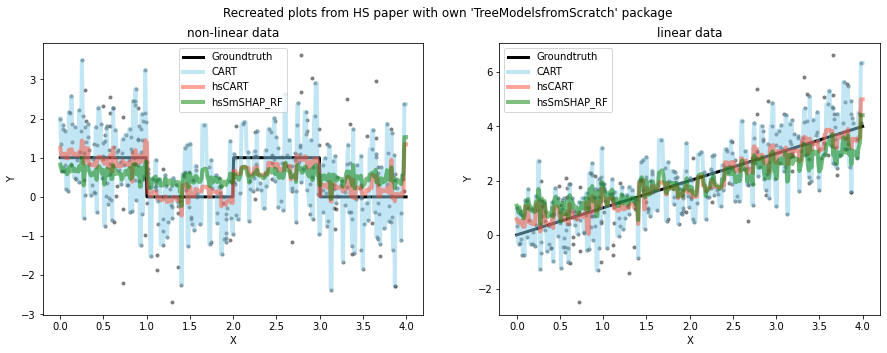

In [273]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Recreated plots from HS paper with own 'TreeModelsfromScratch' package")

_, y_scra_lin, _, _, y_pred_dt_scra_lin, y_pred_shrunk_scra_lin, y_pred_shrunk_scrasm_lin, cv_results_lin = plot_sim(
    n=400, std=1, reg_param=100, use_imodels=False, show='pass', ax=axs[0], return_curves=True, gridsearch_lambda=True)
_, y_scra_nonlin, _, _, y_pred_dt_scra_nonlin, y_pred_shrunk_scra_nonlin, y_pred_shrunk_scrasm_nonlin, cv_results_nonlin= plot_sim(
    n=400, std=1, reg_param=50, use_imodels=False, linear_data=True, show='pass', ax=axs[1], return_curves=True, gridsearch_lambda=True)

axs[1].set_title('linear data')
axs[0].set_title('non-linear data');

# Performance comparison (original HS paper)

### Function

In [7]:
from sklearn.metrics import roc_auc_score

In [29]:
def create_performance_plot_rf(X, y, model_type="classification", cv=10, scoring_func=roc_auc_score, reg_param=100, 
                                  shuffle=True, random_state=42, dset_name=None):

    
    # n_trees as x-axis
    n_trees = [15,25,50,100]

    # estimator_sk = RandomForestClassifier if model_type=="classification" else RandomForestRegressor
    # estimator_im = HSTreeClassifier if model_type=="classification" else HSTreeRegressor    
   
    # new_cv_res_sk = []
    # new_cv_res_im = []
    new_cv_res_scr = []
    new_cv_res_scrHS = []
    new_cv_res_scrHSsmSHAP = []
    grid_cv_results = []
    grid_cv_resultsHS = []
    
    for n_tree in tqdm(n_trees):

        # #sklearn
        # forest_sk = estimator_sk(n_estimators=n_tree, random_state=random_state)
        # new_cv_res_sk.append(cross_val_score_scratch(forest_sk, X, y, cv=cv, scoring_func=scoring_func, 
        #                                          shuffle=shuffle, random_state=random_state))

        # #imodels 
        # forest_im = estimator_im(deepcopy(forest_sk), reg_param=reg_param)
        # new_cv_res_im.append(cross_val_score_scratch(forest_im, X, y, cv=cv, scoring_func=scoring_func, 
        #                                          shuffle=shuffle, random_state=random_state))
        
        #scratch
        forest_scr = RandomForest(n_trees=n_tree, treetype=model_type, random_state=random_state, 
                                  n_feature="sqrt", oob=False)
        new_cv_res_scr.append(cross_val_score_scratch(forest_scr, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))

        #scratchHS
        grid = {"HS_lambda":[0.1,1,5,10,20,50,100]}
        forest_scrHS = RandomForest(n_trees=n_tree, treetype=model_type, n_feature="sqrt", 
                                    HShrinkage=True, random_state=random_state, oob=False)
        grid_cv_resultHS = GridSearchCV_scratch(forest_scrHS, grid, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state)
        grid_cv_resultsHS.append(grid_cv_resultHS)  
        new_cv_res_scrHS.append(grid_cv_resultHS["best_test_scores"])  

        #scratchHS with smooth SHAP
        forest_scrHSsmSH = RandomForest(n_trees=n_tree, treetype=model_type, n_feature="sqrt", 
                                    HShrinkage=False, random_state=random_state, oob=True, 
                                    oob_SHAP=True, HS_smSHAP=True)

        grid_cv_result = GridSearchCV_scratch(forest_scrHSsmSH, grid, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state)
        grid_cv_results.append(grid_cv_result)
        new_cv_res_scrHSsmSHAP.append(grid_cv_result["best_test_scores"])        
        
    #Compute standard error of mean
    # new_data_sk = np.array(new_cv_res_sk)
    # new_sem_data_sk = np.std(new_data_sk, ddof=1, axis=1) / np.sqrt(np.size(new_data_sk, axis=1))

    # new_data_im = np.array(new_cv_res_im)
    # new_sem_data_im = np.std(new_data_im, ddof=1, axis=1) / np.sqrt(np.size(new_data_im, axis=1))
    
    new_data_scr = np.array(new_cv_res_scr)
    new_sem_data_scr = np.std(new_data_scr, ddof=1, axis=1) / np.sqrt(np.size(new_data_scr, axis=1))

    new_data_scrHS = np.array(new_cv_res_scrHS)
    new_sem_data_scrHS = np.std(new_data_scrHS, ddof=1, axis=1) / np.sqrt(np.size(new_data_scrHS, axis=1))

    new_data_scrHSsmSH = np.array(new_cv_res_scrHSsmSHAP)
    new_sem_data_scrHSsmSH = np.std(new_cv_res_scrHSsmSHAP, ddof=1, axis=1) / np.sqrt(np.size(new_cv_res_scrHSsmSHAP, axis=1))
    

    #Create plot
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    
    # axs[0].errorbar(x=n_trees, y=np.array(new_data_im).mean(axis=1), yerr=new_sem_data_im, color="tab:blue", 
    #                alpha=1., linewidth=3, marker="o")
    axs[0].errorbar(x=n_trees, y=np.array(new_data_scrHS).mean(axis=1), yerr=new_sem_data_scrHS, color="tab:blue", 
                   alpha=.5, linewidth=3, marker="o")
    # axs[0].errorbar(x=n_trees, y=np.array(new_data_sk).mean(axis=1), yerr=new_sem_data_sk, color="tab:blue", 
    #                alpha=.5, linewidth=3, marker="o")
    axs[0].errorbar(x=n_trees, y=np.array(new_data_scr).mean(axis=1), yerr=new_sem_data_scr, color="orange", 
                   alpha=.5, linewidth=3, marker="o")
    axs[0].errorbar(x=n_trees, y=np.array(new_data_scrHSsmSH).mean(axis=1), yerr=new_sem_data_scrHSsmSH, color="green", 
                alpha=.5, linewidth=3, marker="o")
    

    axs[0].set_title(f"{dset_name} (n = {X.shape[0]}, p = {X.shape[1]})")
    axs[0].set_xlabel("Number of Trees")
    y_label = "AUC" if str(scoring_func).split()[1]=="roc_auc_score" else "R2"
    axs[0].set_ylabel(y_label)
    axs[0].legend(["hsRF scratch CV", "RF scratch", "hsRF smooth SHAP scratch CV"])
    axs[-1].axis('off')
    plt.show()
    
    return [[new_data_scr, new_sem_data_scr], [new_data_scrHS, new_sem_data_scrHS, grid_cv_resultsHS], [new_data_scrHSsmSH, new_sem_data_scrHSsmSH, grid_cv_results]]

In [ ]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_performance")
today_str = datetime.today().strftime("%Y%m%d")

### Classification

#### Heart dataset (calculated)

In [18]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[1]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

100%|██████████| 4/4 [20:45<00:00, 311.47s/it]


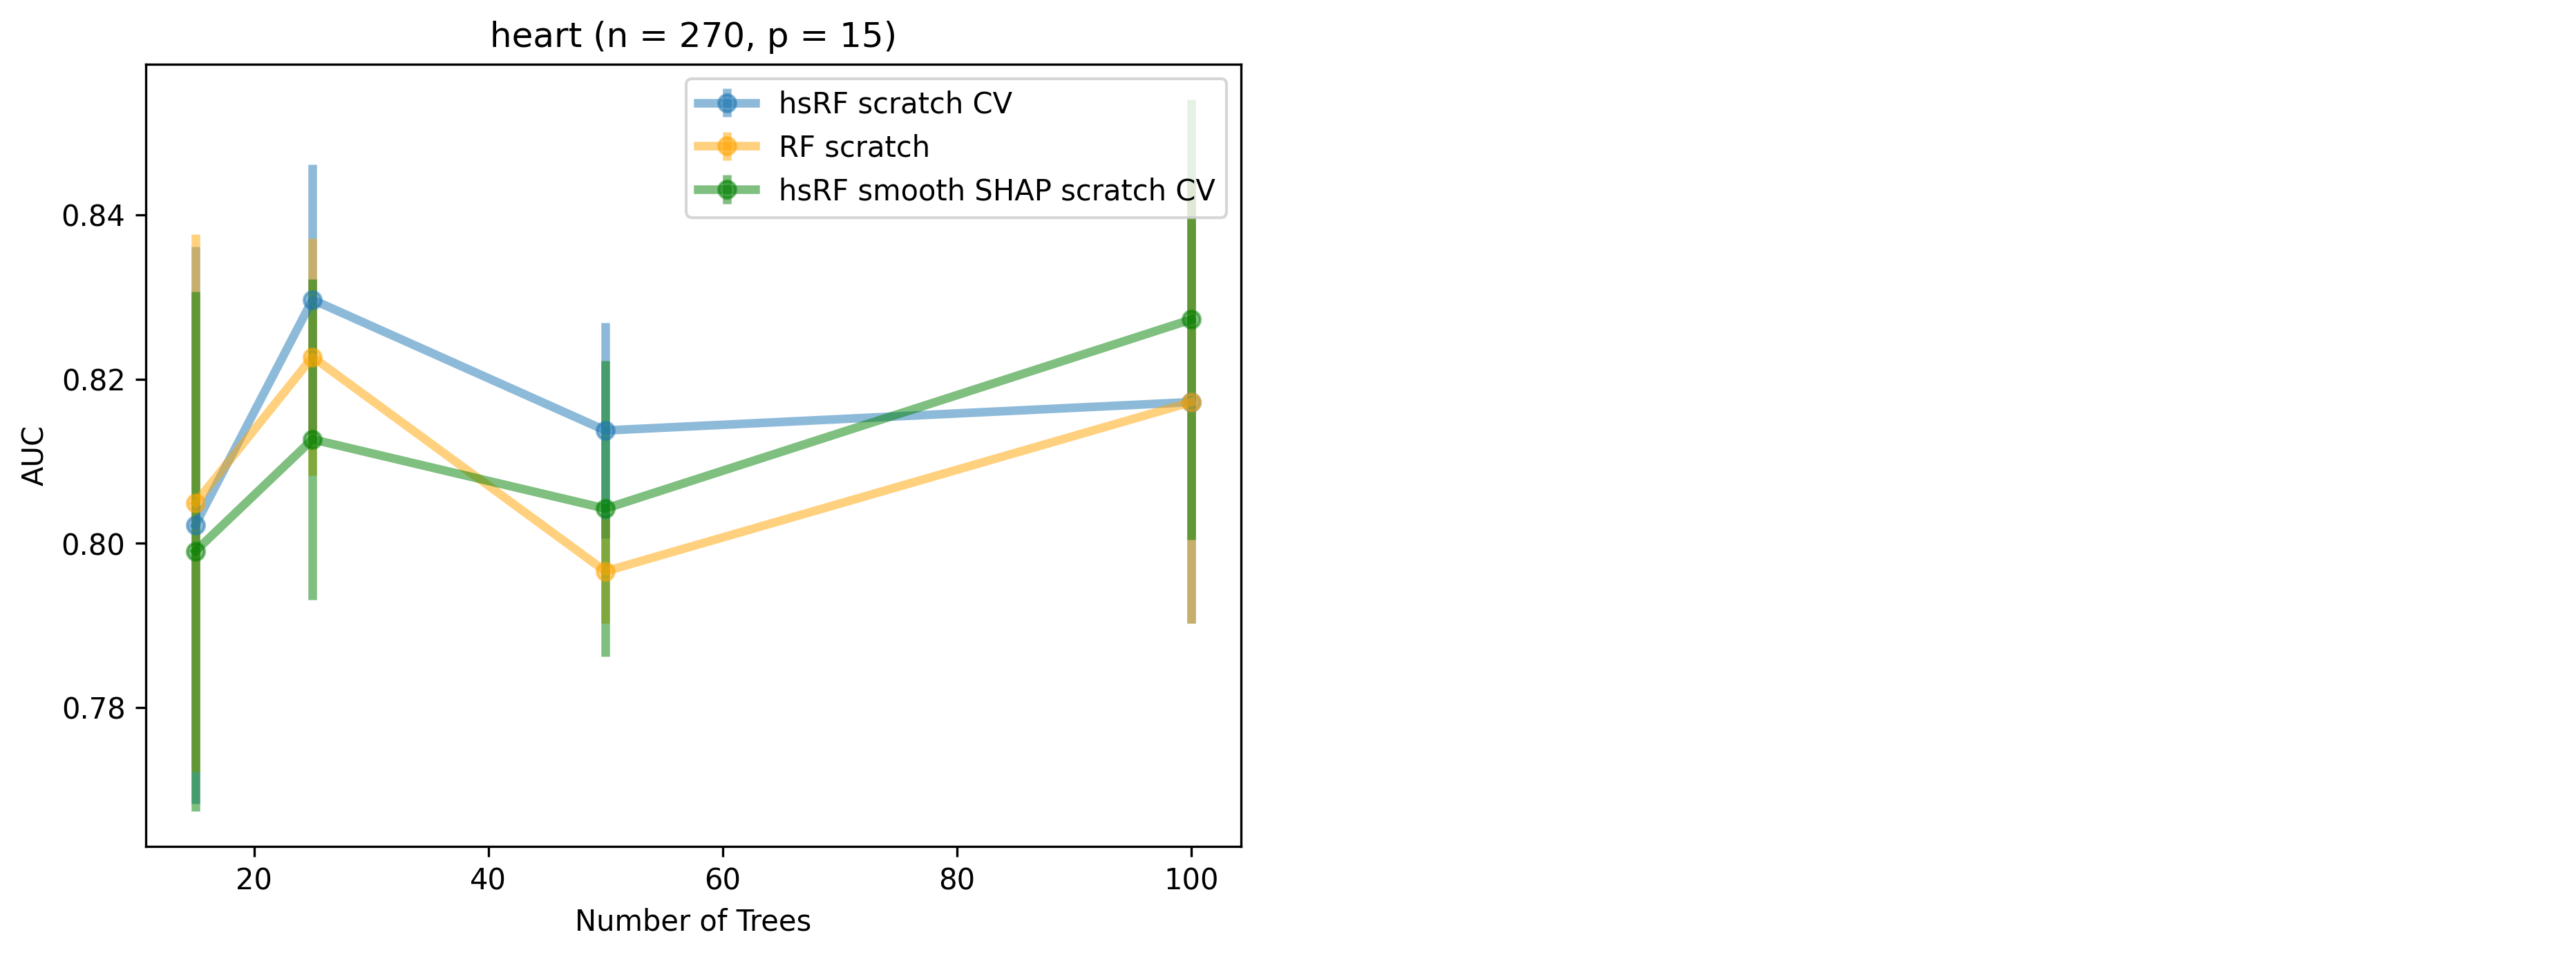

CPU times: user 20min 46s, sys: 627 ms, total: 20min 46s
Wall time: 20min 46s


In [30]:
%%time
cv_res_rf_hea = create_performance_plot_rf(X, y, scoring_func=roc_auc_score, cv=3, model_type="classification",
                                          shuffle=True, random_state=42, dset_name=dset_name)

In [35]:
with open('/home/philipp_heitmann/SelectiveHierarchicalShrinkage/data/HS_performance/20221117_haberman_results.pickle', 'rb') as handle:
    test = pickle.load(handle)

In [37]:
test.keys()

dict_keys(['results_scratch_RF', 'results_scratch_hsRF', 'results_scratch_hsRF_smSHAP', 'simulation_settings'])

In [40]:
test["results_scratch_hsRF"]

{'data': array([[0.63806818, 0.53162055, 0.59463563]]),
 'sem': array([0.03090162]),
 'grid_cv_results': [{'best_param_comb': (20,),
   'best_test_score': 0.5881081209027433,
   'best_test_scores': array([0.63806818, 0.53162055, 0.59463563]),
   'mean_test_scores': array([0.55022447, 0.57096614, 0.58520893, 0.56556588, 0.58810812,
          0.57442272, 0.51777516]),
   'param_combinations': [(0.1,), (1,), (5,), (10,), (20,), (50,), (100,)],
   'cv_scores_p_split': array([[0.55156747, 0.56224696, 0.53685897],
          [0.54487179, 0.61583012, 0.5521965 ],
          [0.61205357, 0.58579545, 0.55777778],
          [0.56831984, 0.56933198, 0.55904582],
          [0.63806818, 0.53162055, 0.59463563],
          [0.5511583 , 0.57072097, 0.60138889],
          [0.54898184, 0.5       , 0.50434363]])}]}

#### Load pickled results

In [5]:
import matplotlib.image as mpimg

In [7]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_performance")

In [8]:
imgs = []
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(data_path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(os.path.join(data_path,f))

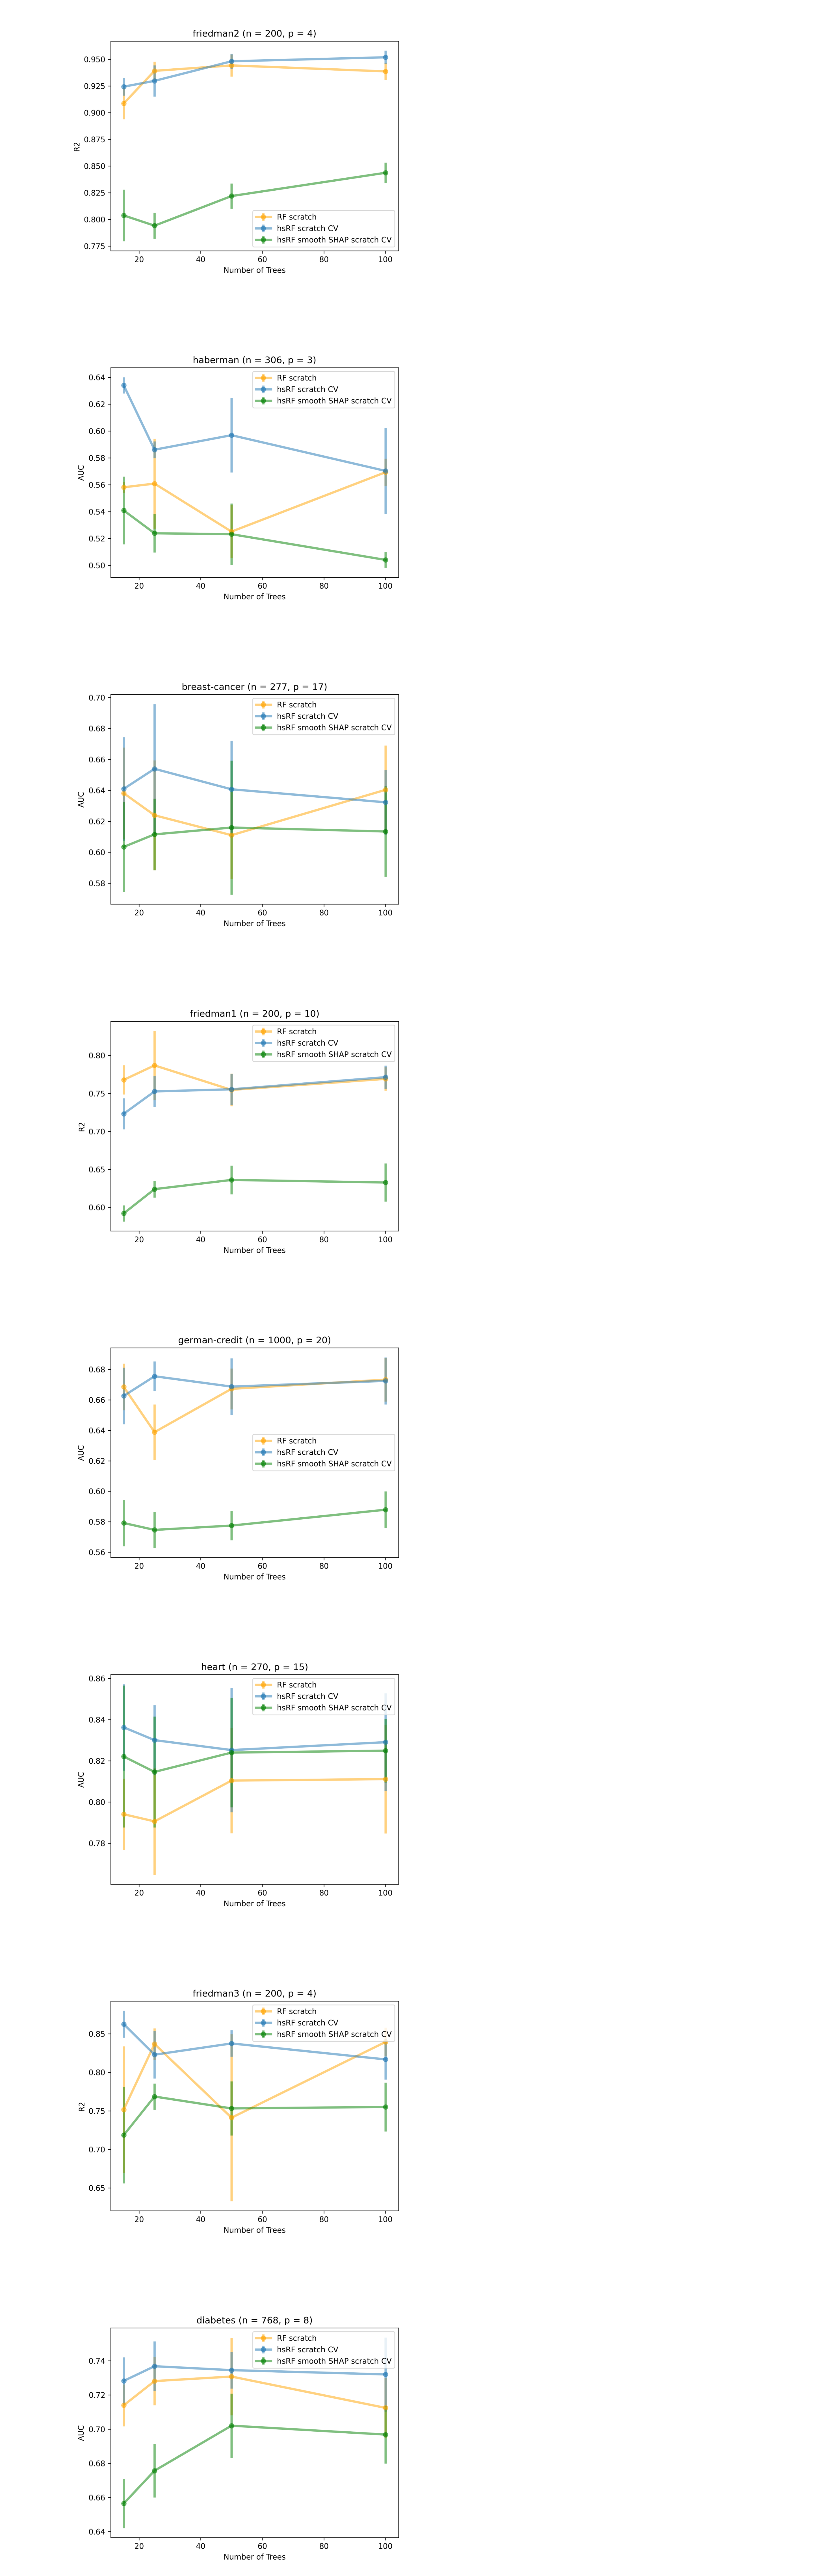

In [26]:
fig, axs = plt.subplots(8,1, figsize=(20,40))

axs = axs.ravel()

for ax, img_path in zip(axs, imgs):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

